# <span style="font-family: Arial, sans-serif; color:#97f788">xbooster</span>
## <span style="font-family: Arial, sans-serif; color:navyblue">Getting started</span>

<span style="font-family: Arial, sans-serif; color:navyblue">Repo: <a href="https://github.com/xRiskLab/xBooster" title="GitHub link">https://github.com/xRiskLab/xBooster</a></span>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://github.com/xRiskLab/xBooster/raw/main/examples/data/credit_data.parquet"
)
dataset = pd.read_parquet(url)

features = [
    "external_risk_estimate",
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = "is_bad"

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

In [2]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.55,
    max_depth=1,
    min_child_weight=10,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(
    **best_params, random_state=62
)
evalset = [
    (X.loc[ix_train], y.loc[ix_train]),
    (X.loc[ix_test], y.loc[ix_test]),
]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train],
    y.loc[ix_train],
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[
    :, 1
]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[
    :, 1
]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(
    f"Train Gini score: {gini_trn:.2%}\n"
    f"Test Gini score: {gini_tst:.2%}"
)

Train Gini score: 89.84%
Test Gini score: 89.11%


In [3]:
# Import necessary modules
from xbooster.constructor import XGBScorecardConstructor

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(
    xgb_model, X.loc[ix_train], y.loc[ix_train]
)

# Construct the scorecard
xgb_scorecard = scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = (
    scorecard_constructor.create_points(
        pdo=50, target_points=600, target_odds=50
    )
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(
    X.loc[ix_test]
)
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore

print(f"Test Gini score: {gini:.2%}")

Test Gini score: 89.09%


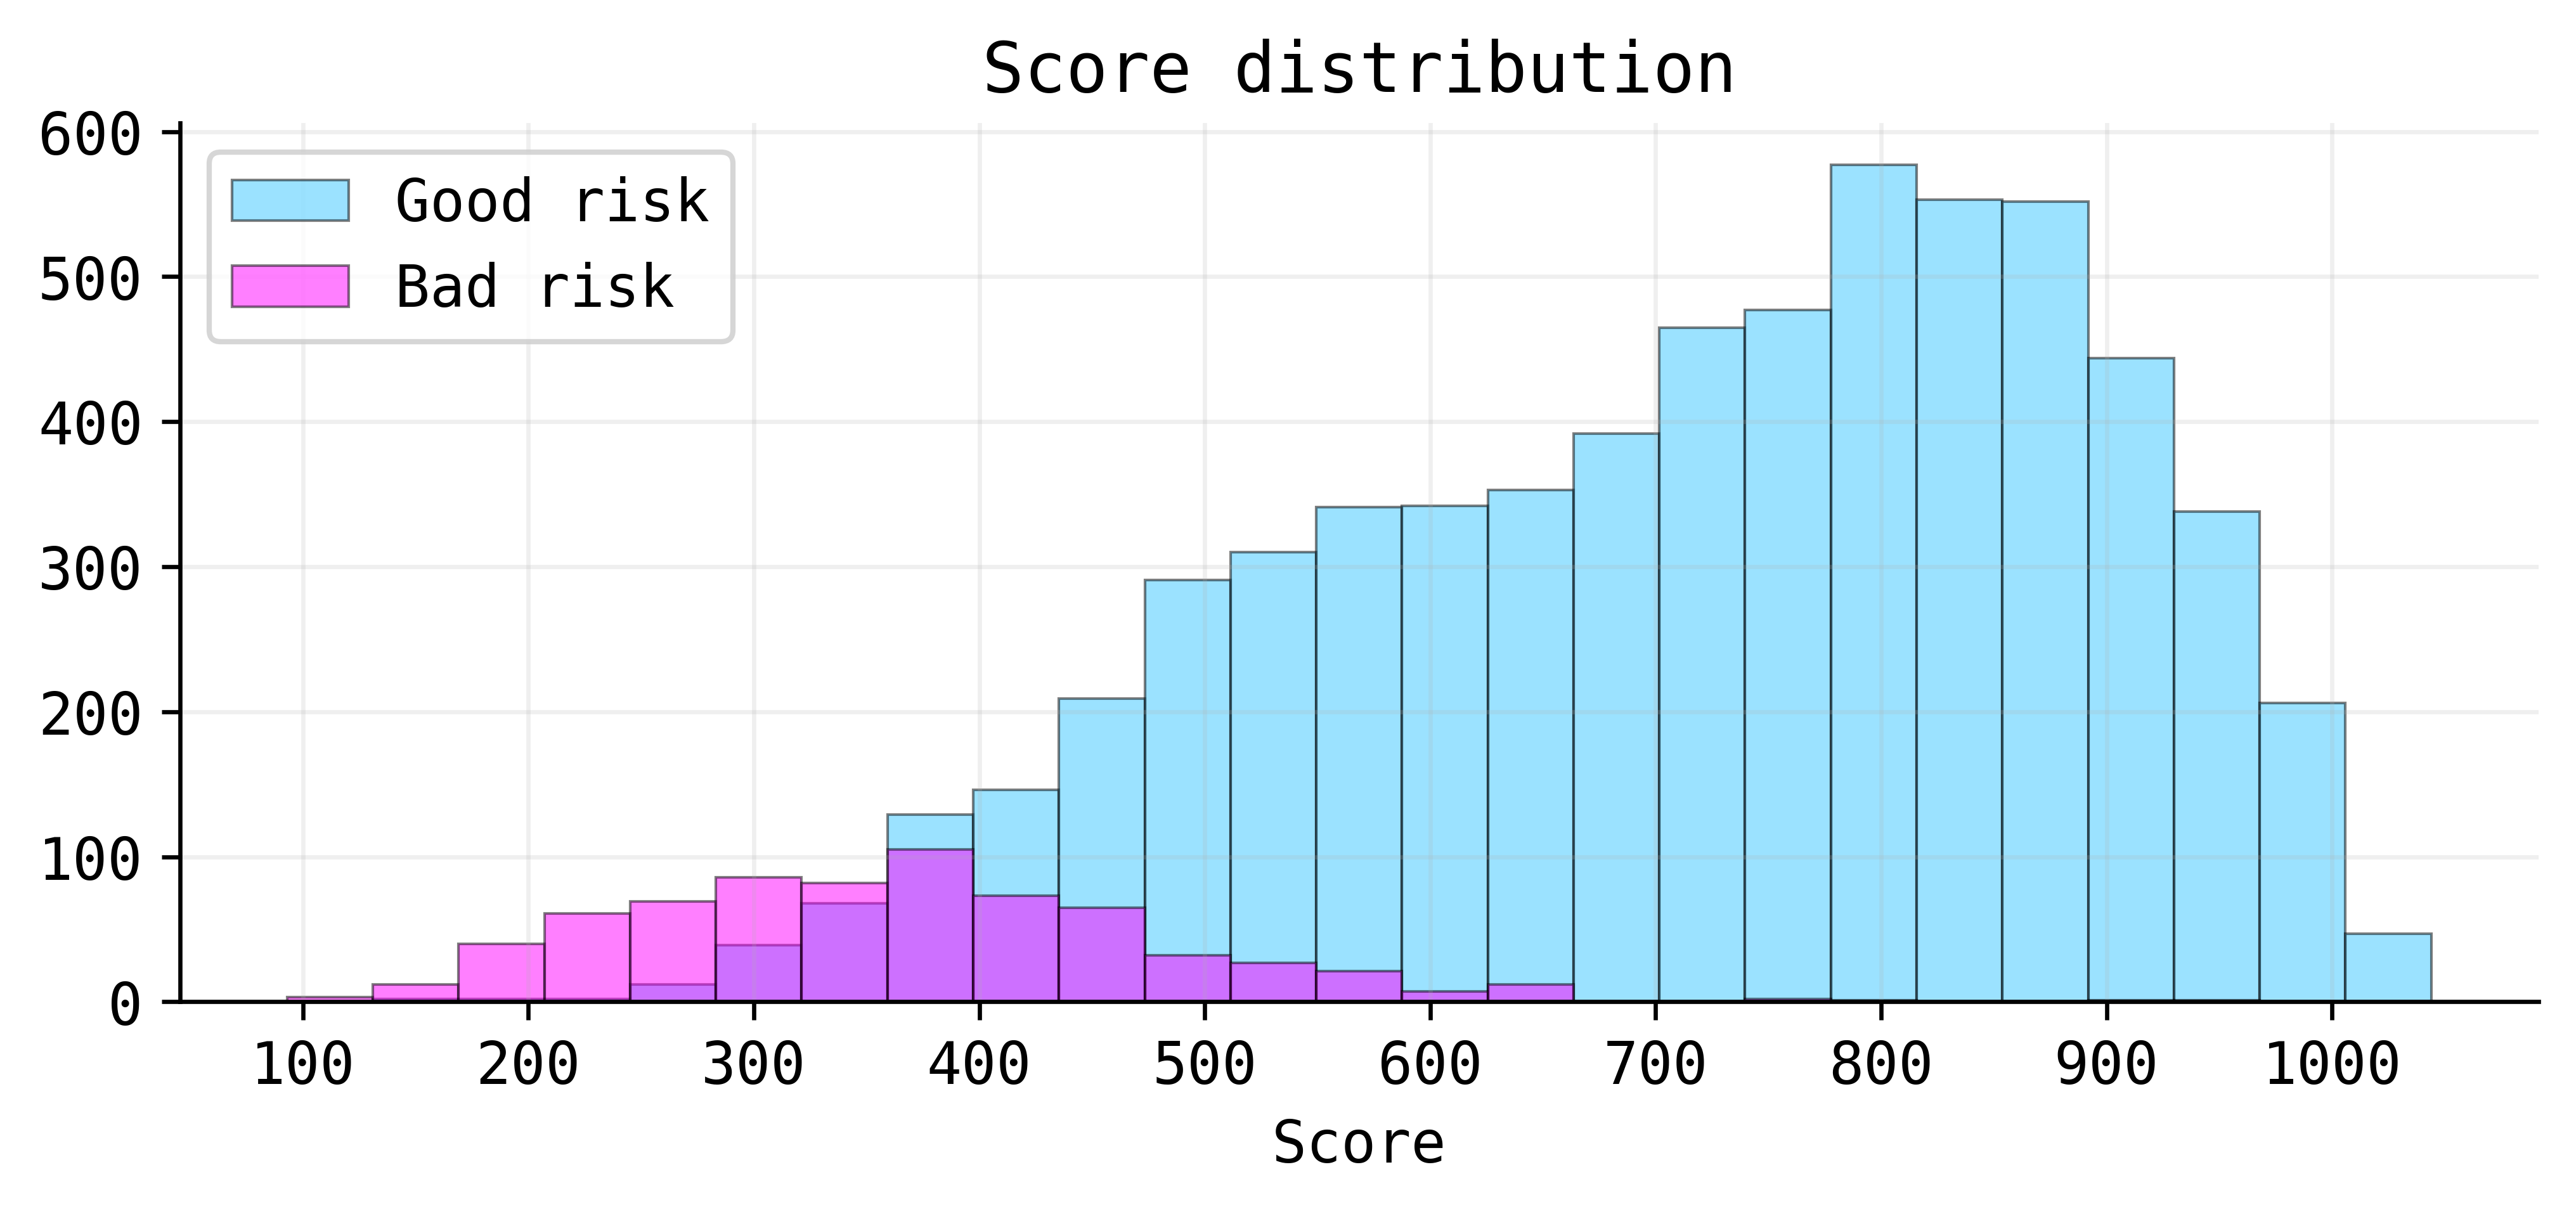

In [4]:
from xbooster.explainer import plot_score_distribution

# Plot score distribution
plot_score_distribution(
    scorecard_constructor=scorecard_constructor,
    fontsize=11,
    figsize=(8, 3),
    dpi=600,
)

### Scorecard

In [25]:
# import dataframe_image as dfi
# df = xgb_scorecard_with_points.query("Tree < 3")
# dfi.export(df, "df.png", dpi=500)

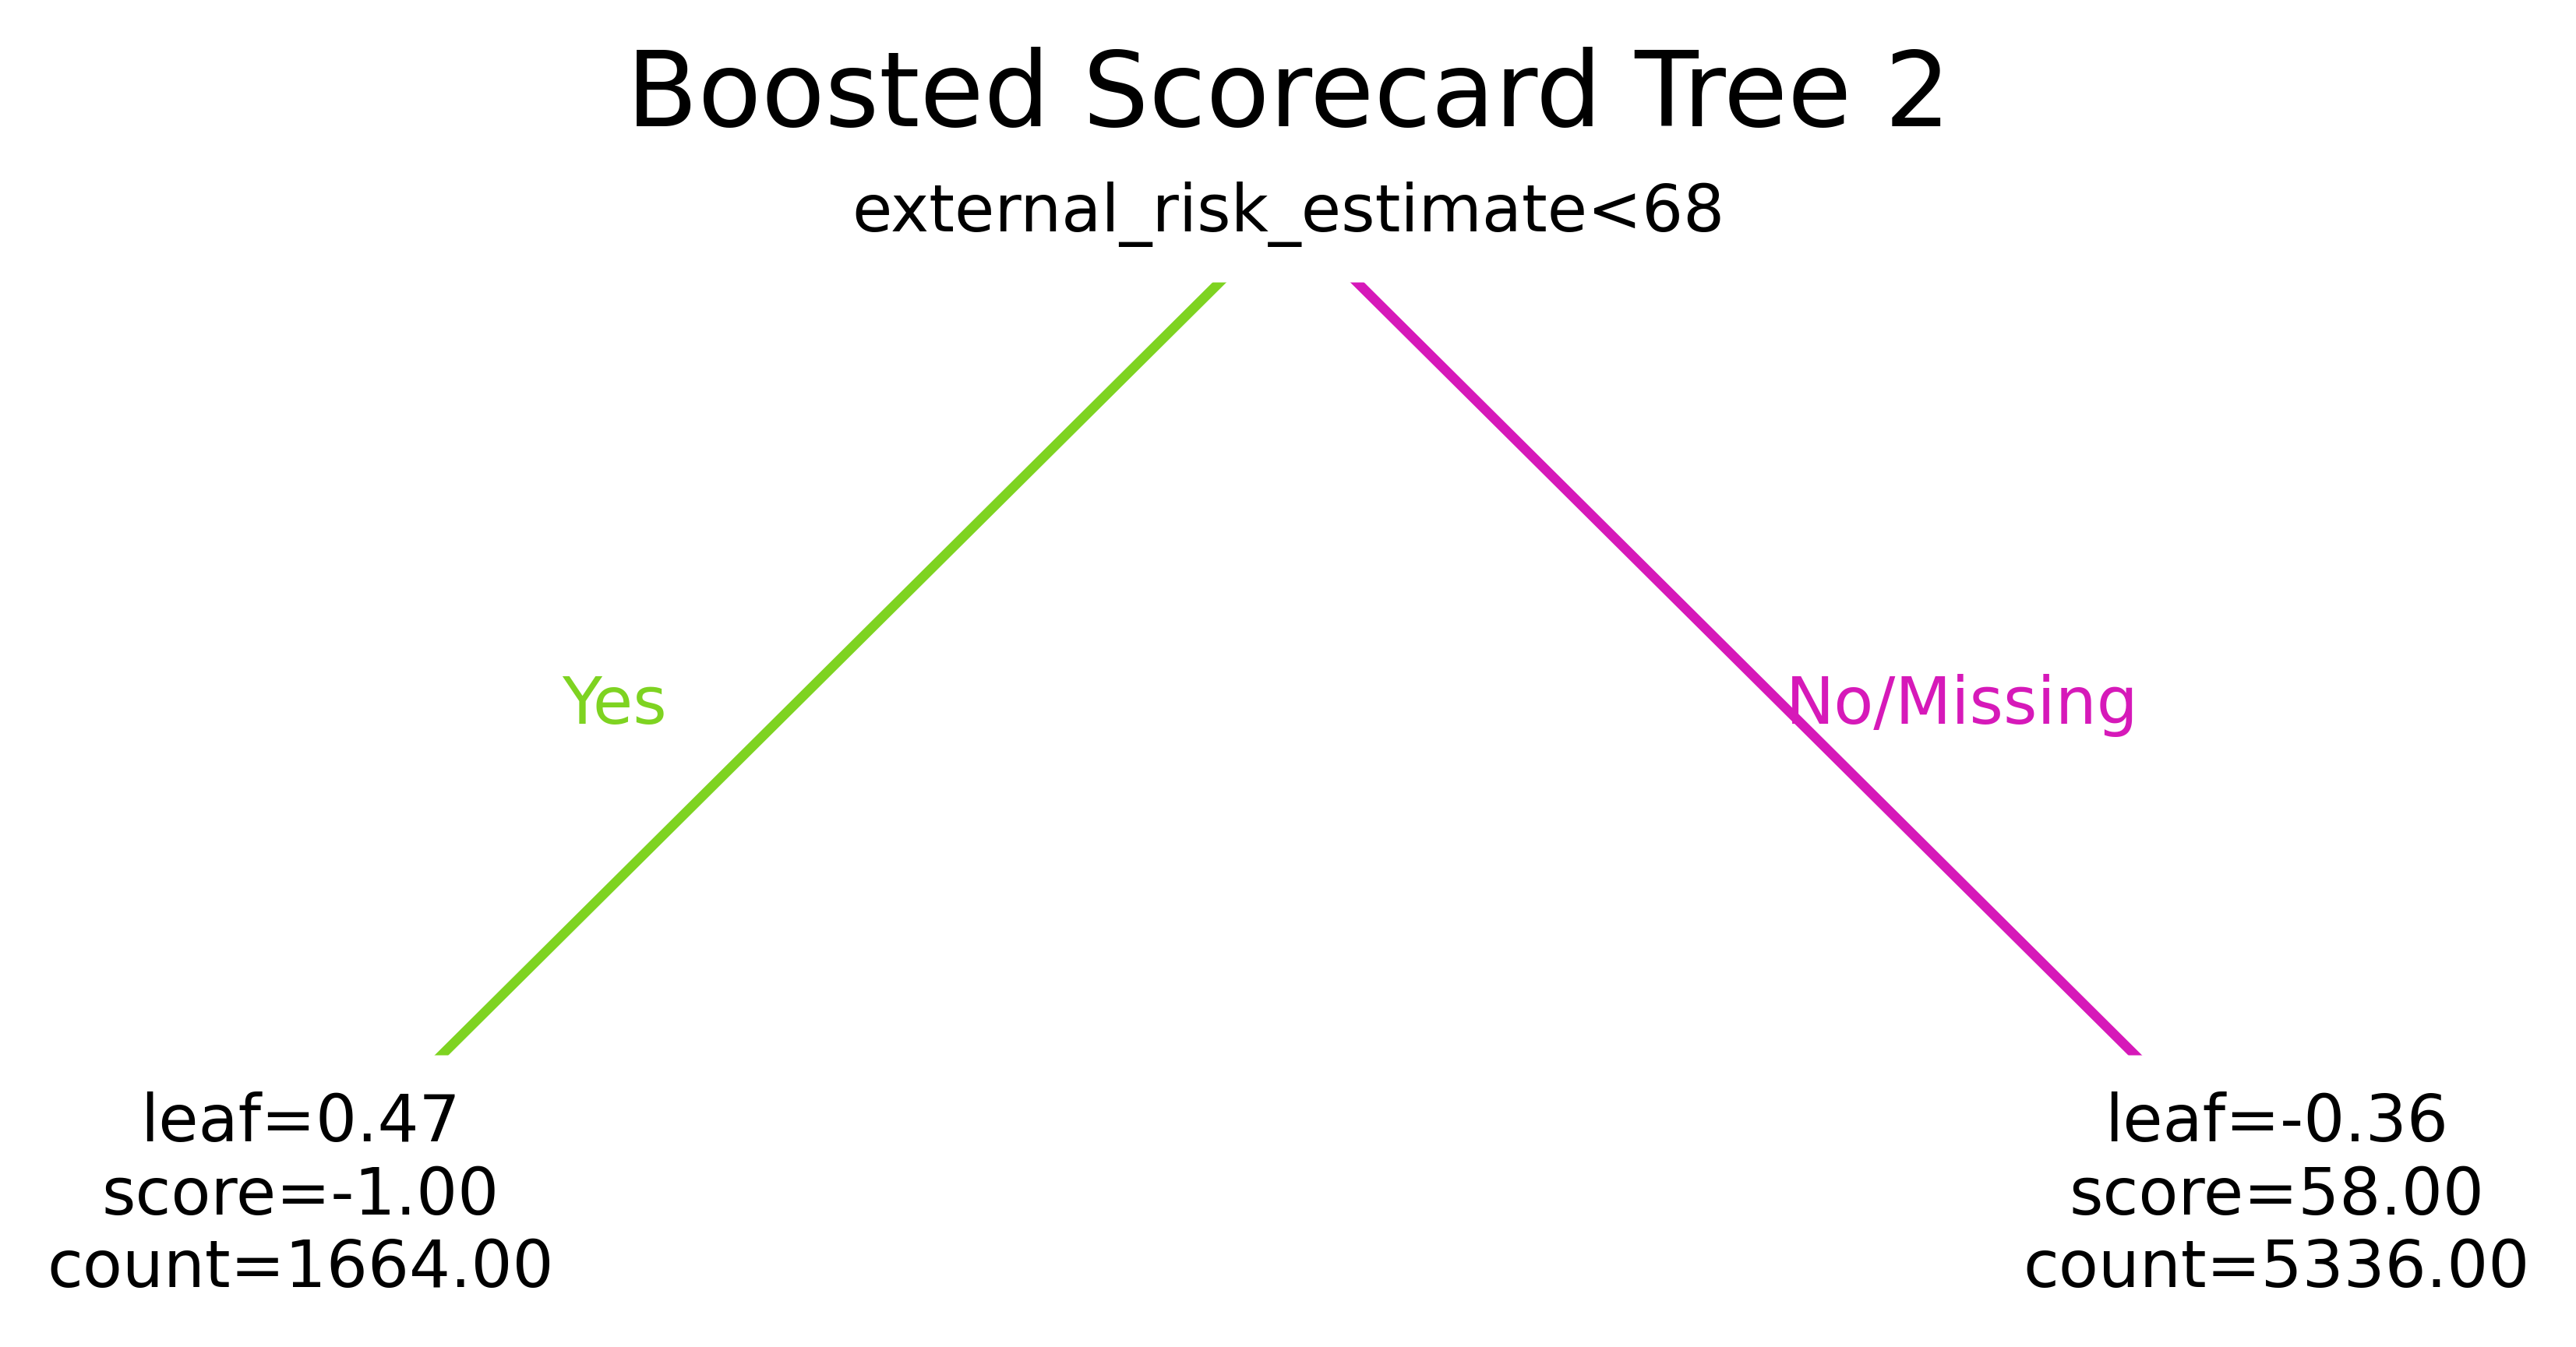

In [5]:
from xbooster.explainer import TreeVisualizer
from matplotlib import pyplot as plt

tree_viz = TreeVisualizer(
    metrics=["Points", "Count"], precision=2
)

tree_id = 2

plt.figure(figsize=(6, 3), dpi=600)
tree_viz.plot_tree(scorecard_constructor, num_trees=tree_id)
plt.title(f"Boosted Scorecard Tree {tree_id}", fontsize=16)
plt.show()

### Interpretability

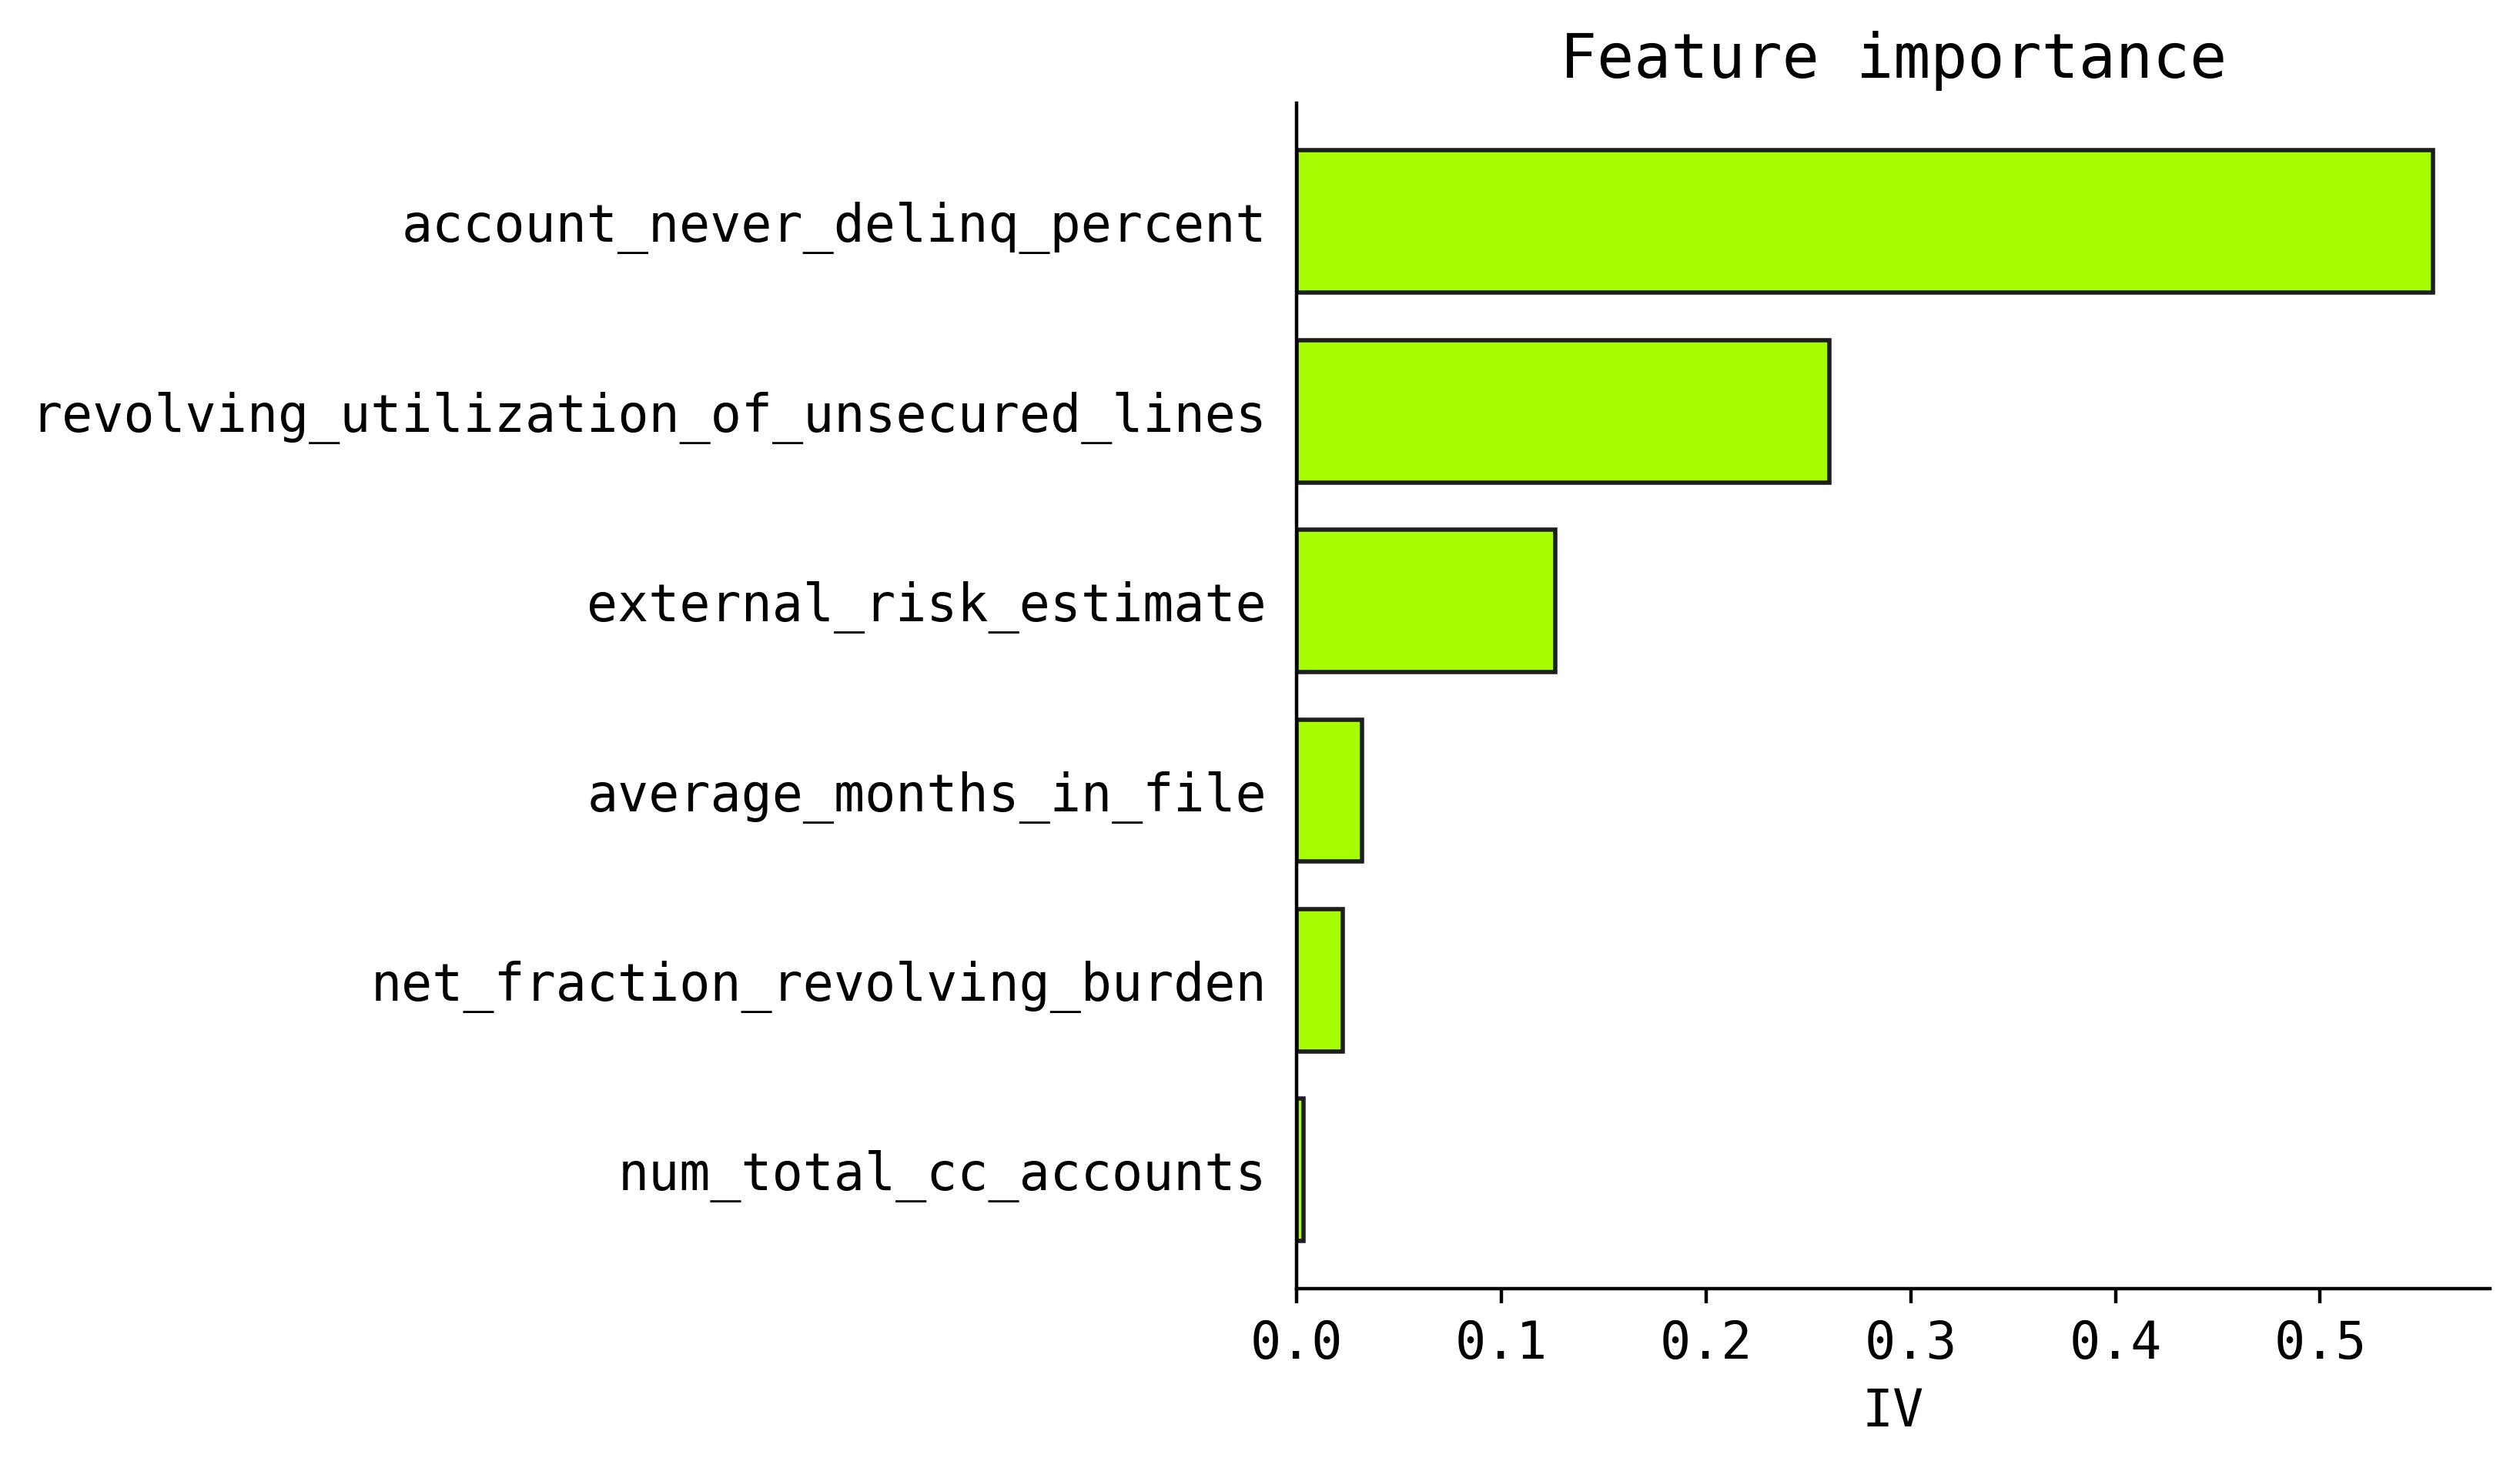

In [35]:
from xbooster.explainer import plot_importance

plot_importance(
    scorecard_constructor,
    metric="IV",
    method="global",
    normalize=True,
    color="#a7fe01",
    edgecolor="#1e1e1e",
    figsize=(5, 5),
    dpi=200,
    title="Feature importance",
)

In [34]:
from xbooster import explainer
%config InlineBackend.figure_format = 'retina'

# Choose a sample
sample_idx = 2

explainer.plot_local_importance(
    scorecard_constructor,
    X.loc[ix_test][sample_idx : sample_idx + 1],
    figsize=(6, 6),
    fontsize=14,
    dpi=500,
    title="Local feature importance",
)